# inlezen en inbrengen van de data naar variabelen

## inlezen van  de data zelf

We beginnen met het inlezen van de data via een with statement waar we de data als een array van strings inlezen.
Zo kunnen we deze array in een parse functie steken die elke string afloopt, en split via het & teken. Als we kijken naar een stuk van de data zullen we zien waarom:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
lines = []

with open("DataScienceData01.txt","r") as infile:
    lines = infile.readlines()
if True:
    with open("DataScienceData02.txt", "r") as infile:
        lines.extend(infile.readlines())
    

if True:
    with open("DataScienceData03.txt", "r") as infile:
        lines.extend(infile.readlines())

print(lines[1])



Time=12/03 06:08:53& Sender=44:6E:E5:C5:8F:4F& Location=gang@0.61875;0.13758& WifiInfo=ODISEE@88-1d-fc-30-d4-40:-74,campusroam@88-1d-fc-30-d4-43:-74,ODISEE@88-1d-fc-30-d5-50:-72,eduroam@88-1d-fc-30-d4-42:-74,eduroam@88-1d-fc-30-d5-52:-72,campusroam@88-1d-fc-30-d5-53:-73,ODISEEGuest@88-1d-fc-30-d4-41:-75,ODISEEGuest@88-1d-fc-30-d5-51:-73,CiscoC5976@58-6d-8f-19-14-38:-82,rechts@58-6d-8f-19-10-fc:-59,ODISEE@88-1d-fc-41-dc-50:-81,eduroam@88-1d-fc-41-dc-52:-81,campusroam@88-1d-fc-41-dc-53:-67,eduroam@88-1d-fc-2c-c0-02:-78,campusroam@88-1d-fc-2c-c0-03:-71,ODISEE@88-1d-fc-2c-c0-00:-77,telenet-5467D@dc-53-7c-85-46-82:-87,ODISEEGuest@88-1d-fc-41-dc-51:-80,ODISEEGuest@88-1d-fc-2c-c0-01:-73,CiscoC5959@58-6d-8f-19-13-f4:-81,TELENETHOMESPOT@02-53-7c-85-46-83:-86



## parsen van de data

Zoals hierboven te zien is is onze input een collectie van lijnen waar elke lijn een instance van een meting is. Er is een time onderdeel, sender (bestaande uit een mac address), location (bestaande uit een locatie naam, xcoordinaat als percentage en ycoordinaat als percentage) en een wifiinfo onderdeel wat bestaat uit een lijst van ssid's met hun mac-address en signaal sterkte.

Om deze data te parsen werdt er gekozen voor een entry te maken voor elke ssid die in wifiinfo te vinden is. Op deze manier is er een entry van elk ontvangbaar access-point vanaf elke sender.

Daarboven op zullen we ook een x en y coordinaat toevoegen die volledig zijn ipv een percentage. Dit maakt het process later makkelijker omdat we dan niet de bewerking opnieuw moeten doen. (bewerking = locatienaam + .png inladen en width en height van de image vermenigvuldigen met x en y)

Er zijn ook meerdere keren dezelfde ssid aanwezig met andere mac addressen. Dit komt omdat meerdere accesspoints dezelfde ssid's verzenden, en er zijn deels gelijke mac addressen aanwezig. Dus door een deel van het mac address apart te steken kunnen we access point specifieke data inlezen.




In [2]:
def dataParse(l):
    objs = l.split("& ")
    dic = {}
    for obj in objs:
        items = obj.split("=")
        title = items[0]
        data = items[1].split(",")
        if len(data) == 1:
            data = data[0]
        if title == "Location":
            temp = data.split("@")
            naam = temp[0].lower()
            x, y = temp[1].split(";")
            dic["location"] = naam
            img = plt.imread(naam+'.png')
            height, width, channels = img.shape
            dic["x"] = float(x) * width
            dic["y"] = float(y) * height
            dic["px"] = float(x)
            dic["py"] = float(y)
            continue
        if title == "WifiInfo":
            appendable = []
            for f in data:
                append = {}
                temp = f.replace("\n",'').split('@')
                ti = temp[0]
                append["ssid"] = ti
                temp = temp[1].split(":")
                append["mac"] = temp[0]
                append["routerId"] = "".join(temp[0].split('-'))[:-2]
                #print(append["routerId"])
                append["signal"] = float(temp[1])
                appendable.append(append)
            dic[title] = appendable
            continue
        dic[title] = data
    finale = []
    for i in dic['WifiInfo']:
        f = {}
        f["time"] = dic['Time']
        f['sender'] = dic['Sender']
        f['location'] = dic['location']
        f['x'] = dic['x']
        f['y'] = dic['y']
        f["px"] = dic["px"]
        f["py"] = dic["py"]
        f['ssid'] = i['ssid']
        f['mac'] = i['mac']
        f['routerId'] = i["routerId"]
        f['name'] = i['ssid']+"@"+i['mac']
        f['signal'] = i['signal']
        finale.append(f)
    return finale 


data = []
for l in lines:
   data.extend(dataParse(l))




df = pd.DataFrame(data)


## het in beeld brengen van de data

Aan de hand van de locatie van de items in de dataframe kunnen we een scatterplot maken overheen de images. We zullen beginnen met de senders te tonen.

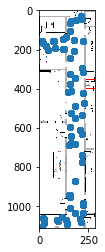

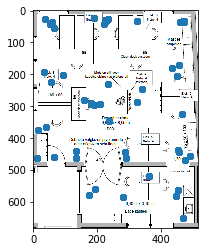

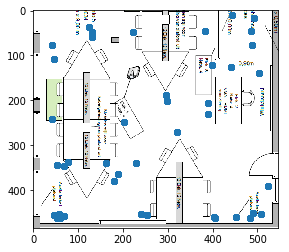

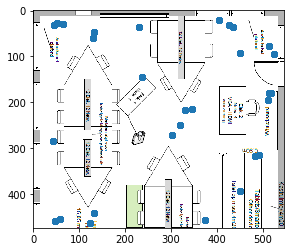

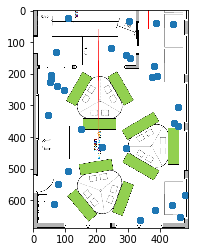

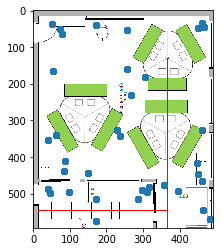

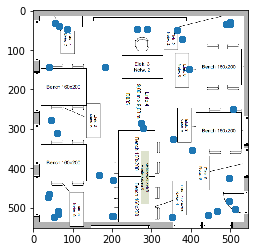

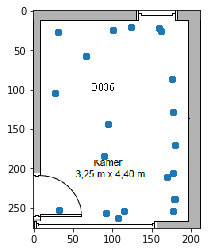

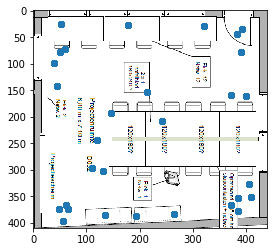

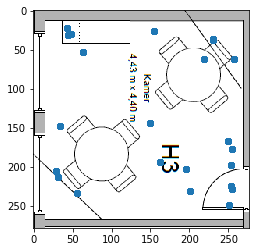

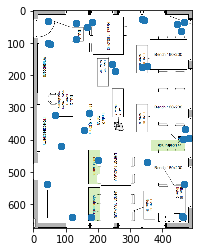

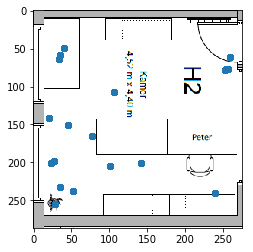

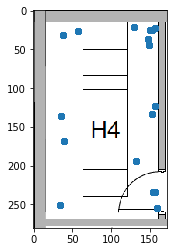

In [3]:
for i in df.location.unique():
    temp = df.loc[df["location"] == i]
    plt.scatter(temp.x, temp.y)
    #print(i)
    img = plt.imread(i+'.png')
    #print(img)
    plt.imshow(img)
    plt.show()

De volgende stap is om de meetpunten zelf in beeld te brengen. Door onze x en y coords te mappen per routerid en dan het signal te mappen op de c value in een scatter plot krijgen we een heatmap. Deze functie zal dus later herbruikt worden om de data te tonen.


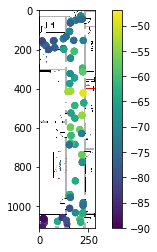

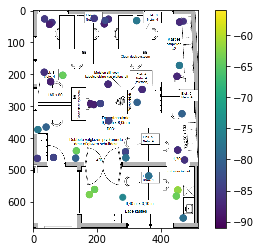

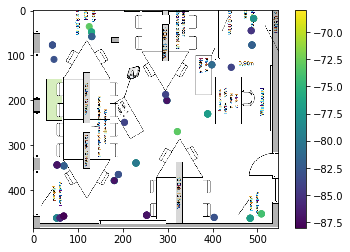

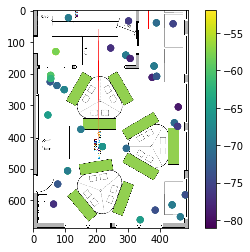

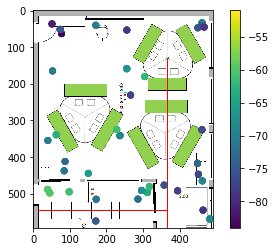

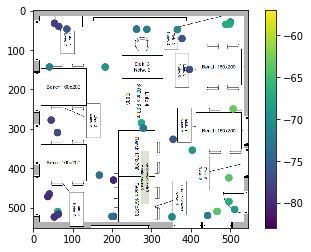

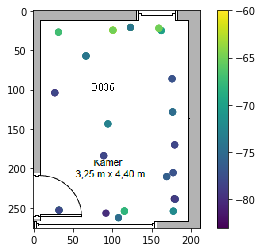

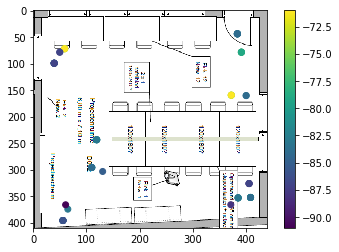

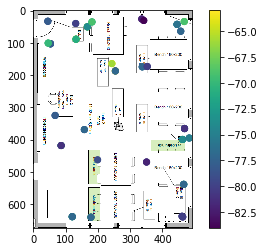

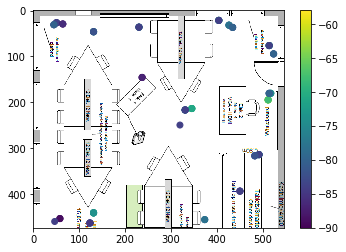

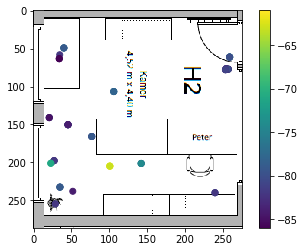

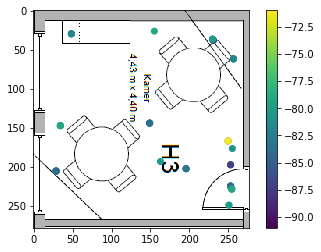

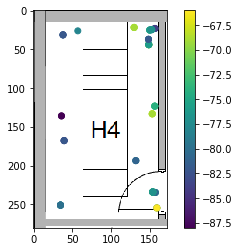

volgend routerid 





In [4]:
def displayData(df, s="Displaying room {}", amount = -1):
    locs = df.location.unique()
    for loc in locs:
        tdf = df.loc[df["location"] == loc]
        x, y, z = tdf.x, tdf.y, tdf.signal
        img = plt.imread(loc.lower()+".png")
        plt.scatter(x, y, c=z)
        plt.colorbar()
        plt.imshow(img)
        plt.show()
        amount -= 1
        if amount == 0:
            return
    return

for t in df.routerId.unique():
    displayData(df.loc[df["routerId"] == t], s="locatie = {} en routerid addr = {}".format("{}", t))
    print("volgend routerid \n\n\n")
    break

Wat we hier kunnen zien is dat we soms toch wel meetpunten hebben op een identieke plek met redelijk gelijkaardige resultaten. Dit zorgt ervoor dat een trainingset van deze data niet divers genoeg is en we zullen hier dus enkele entries uit moeten halen.


# selectie van de data

Een functie (closetoothers) krijgt een item, en een lijst van objects samen met een percentage en gaat zo de dataframe van deze lijst af om te kijken of er gelijkaardige items al aanwezig zijn in de lijst (op basis van het x en y coordinaat). Als dit niet zo is wordt het item toegevoegd aan de lijst en de lijst gereturned. Dit wordt dan gelooped in de removeIrrelevant functie en zal dan onze gefilterde lijst terug geven.

Na wat research (https://www.metageek.com/training/resources/wifi-signal-strength-basics.html) kunnen we zien dat signalen onder -80 db onbruikbaar zijn, en signalen vanaf -70db okay zijn. Hier zal dus mee gespeeld worden bij de CloseToOthers functie om een bruikbare set te creeeren.

In [5]:

    
def removeIrelevant(df, minSampleSize=50):
    rdf = []
    returnable = pd.DataFrame()
    for i, v in df.iterrows():
        rdf = CloseToOthers(v, rdf)
    rdf = pd.DataFrame(rdf)
    for i in rdf.location.unique():
        trdf = rdf.loc[rdf['location'] == i]
        for j in trdf.routerId.unique():
            ttrdf = trdf.loc[trdf['routerId'] == j]
            #print(ttrdf.head())
            if len(ttrdf) < minSampleSize:
                rdf.drop(ttrdf.index)
    return rdf

def CloseToOthers(i, df, percentage = .1, sig = -80):
    tdf = pd.DataFrame(df)
    approved = []
    if "location" in tdf:
        l = tdf.loc[tdf["location"] == i["location"]]
        l2 = l.loc[l["routerId"] == i["routerId"]]
        for dump, j in l2.iterrows():
            if not (j.sender == i.sender):
                temp = abs(j.px - i.px)
                temp2 = abs(j.py - i.py)
                temp3 = abs(j.signal - i.signal)
                if temp <= percentage and temp2 <= percentage and temp3 <= percentage:
                    return df
                #else:
                    #print(i)
        df.append(i)
        return df
    else:
        df.append(i)
        return df
    



In [ ]:
g = removeIrelevant(df)
print("oud: {} \nNieuw: {}".format(len(df), len(g)))

# Voorbereiden model

## TrainingData Voorbereiden

door het gebruik van traintestsplit kunnen we onze trainingsdata splitten zodat we later een test set kunnen gebruiken om te kijken hoe effectief onze trainingsdata is. onze x data zullen de meet coordinaten zijn en onze y data zal de signaal sterkte van deze punten zijn. Op die manier kunnen we een model fitten en daarna het signaal predicten voor bepaalde coordinaten.

Door een Scaler te gebruiken kunnen we onze trainingsdata rescalen en kijken wat het effect hiervan is. Hieronder zijn alle voorbeelden van scalers die gebruikt werden te vinden.

Er zal ook een display functie aangemaakt worden zodat we de eigenlijke effecten van deze models kunnen bekijken. Dit wordt gedaan door een value te predicten voor elke x, y overheen de afbeelding.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

def prepTrainingmk1(df, random_state=2):
    tx = df["x"]
    ty = df["y"]
    y = df["signal"]
    x = np.column_stack((tx, ty))
    if x.shape[0] < 2:
        return 0, 0, 0, 0, False
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=random_state)
    return xtest, ytest, xtrain, ytrain, True

def prepTrainingmk2(df, random_state=2):
    tx = df["x"].tolist()
    ty = df["y"].tolist()
    y = df["signal"]
    x = np.column_stack((tx, ty))
    scaler = StandardScaler()
    tmp = x.shape
    #print(tmp[0])
    if x.shape[0] < 2:
        return 0, 0, 0, 0, False
    xtrain, xtest, ytrain, ytest = train_test_split(x, y)
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
    return xtest, ytest, xtrain, ytrain, True


def prepTrainingmk3(df, random_state=2):
    tx = df["x"].tolist()
    ty = df["y"].tolist()
    y = df["signal"]
    x = np.column_stack((tx, ty))
    scaler = Normalizer()
    tmp = x.shape
    #print(tmp[0])
    if x.shape[0] < 2:
        return 0, 0, 0, 0, False
    xtrain, xtest, ytrain, ytest = train_test_split(x, y)
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
    return xtest, ytest, xtrain, ytrain, True

def prepTrainingmk4(df, random_state=2):
    tx = df["x"].tolist()
    ty = df["y"].tolist()
    y = df["signal"]
    x = np.column_stack((tx, ty))
    scaler = MaxAbsScaler()
    tmp = x.shape
    #print(tmp[0])
    if x.shape[0] < 2:
        return 0, 0, 0, 0, False
    xtrain, xtest, ytrain, ytest = train_test_split(x, y)
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
    return xtest, ytest, xtrain, ytrain, True



def prepTraining(df, random_state=2):
    tx = df["x"].tolist()
    ty = df["y"].tolist()
    y = df["signal"]
    x = np.column_stack((tx, ty))
    tmp = x.shape
    if x.shape[0] < 2:
        return 0, 0, 0, 0, False
    xtrain, xtest, ytrain, ytest = train_test_split(x, y)
    if len(xtest) < 3 or len(ytest) < 3:
        return 0, 0, 0, 0, False
    scaler = MinMaxScaler(feature_range=(-100,0))
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
    return xtest, ytest, xtrain, ytrain, True


def displayModel(t, stepSize =5, alpha=1):
    for lokaal in t:
        img = plt.imread(lokaal+".png")
        height, width, channels = img.shape
        for router in t[lokaal]:
            if t[lokaal][router] is None:
                continue
            print("Lokaal {} routermac {}".format(lokaal, router))
            z, xx, yy = [], [], []
            for i in range(1, width+1, stepSize):
                for j in range(1, height+1, stepSize):
                    xx.append(i)
                    yy.append(j)
                    np.column_stack((i, j))
                    z.append(t[lokaal][router].predict(np.column_stack((i, j)))[0])
            plt.scatter(xx, yy, c=z, alpha=alpha)
            plt.colorbar()
            plt.imshow(img)
            plt.show()

def display1Model(t, stepSize=5):
    for lokaal in t:
        img = plt.imread(lokaal+".png")
        height, width, channels = img.shape
        for router in t[lokaal]:
            print("Lokaal {} routermac {}".format(lokaal, router))
            z, xx, yy = [], [], []
            if t[lokaal][router] is None:
                continue
            for i in range(1, width+1, stepSize):
                for j in range(1, height+1, stepSize):
                    xx.append(i)
                    yy.append(j)
                    np.column_stack((i, j))
                    z.append(t[lokaal][router].predict(np.column_stack((i, j)))[0])
            plt.scatter(xx, yy, c=z, alpha=.1)
            plt.colorbar()
            plt.imshow(img)
            plt.show()
            break

## Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def train(df, debug=False, results=False, fullScore=False):
    succCount = 0
    total = 0
    models = dict.fromkeys(df.location.unique(), {})
    for i in df.location.unique():
        temp = df.loc[df["location"] == i]
        for j in temp.routerId.unique():
            temp2 = temp.loc[temp["routerId"] == j]
            xtest, ytest, xtrain, ytrain, succ = prepTraining(temp2)
            if not succ:
                models[i][j] = None
                continue
            if len(xtrain) == 0 or len(ytrain) == 0:
                if debug:
                    print(temp2)
                continue
            lr = LinearRegression(n_jobs=-1).fit(xtrain, ytrain)
            models[i][j] = lr
            if results:
                ##rint("xtest {} ytest {} xtrain {} ytrain {}".format(xtest, ytest, xtrain, ytrain))
                if fullScore:
                    for i, v in enumerate(xtest):
                        #print(v)
                        #print(i)
                        #print(ytest)
                        f = lr.score(xtest, ytest)
                        print(f)
                result1 = lr.score(xtest, ytest) > .7
                result = KFold(n_splits=3)
                #print("Cross-validation scores:\n{}".format(cross_val_score(lr, xtest, ytest, cv=result)))
                if cross_val_score(lr, xtest, ytest, cv=result).mean() > .5:
                    succCount += 1
                total += 1
                continue
            print("training data for {} with routerid {}".format(i, j))
            print("lr.coef_:", lr.coef_)
            print("lr.intercept_:", lr.intercept_)
            print("Training set score: {:.2f}".format(lr.score(xtrain, ytrain)))
            print("Test set score: {:.2f}".format(lr.score(xtest, ytest)))
            #displayData(temp2 ,"{}")
            print("\n\n\n")
    if results:
        print("{} / {}".format(succCount, total))
    return models

In [ ]:


#a = train(df, results=True)
b = train(pd.DataFrame(g), results=True)
#print("FullDataFrame")
#displayModel(a)
print("Selection")
displayModel(b)


## SVR

Volgens mij het meest passende model bij deze opgave. Lineare regressie heeft een probleem met een router passeren / andere problemen die bij lineare modellen komen. De oplossing hiervoor is een niet lineare model. Hiervoor heb ik svc gekozen. Aan de hand van enkele voorbeelden heb ik gezien dat dit nuttig kan zijn voor een heatmap te maken van een punt dat de max is van de dataset. Ipv lineare modellen die een rechte tekenen in de richting van dit punt, zal dit model in 360 graden rond dit punt de heatmap correct genereren.

In [ ]:
from sklearn.svm import SVR


def trainSvc(df, debug=False, results=False):
    RsuccCount, succCount = 0, 0
    total = 0
    models = dict.fromkeys(df.location.unique(), {})
    for i in df.location.unique():
        temp = df.loc[df["location"] == i]
        for j in temp.routerId.unique():
            temp2 = temp.loc[temp["routerId"] == j]
            xtest, ytest, xtrain, ytrain, succ = prepTraining(temp2)
            if not succ:
                models[i][j] = None
                continue
            if len(xtrain) == 0 or len(ytrain) == 0:
                if debug:
                    print(temp2)
                continue
            #lr = SVR(kernel='rbf', C=1, gamma="auto_deprecated", epsilon=0.8).fit(xtrain, ytrain)
            lr = SVR(kernel='rbf', C=1, gamma="scale", epsilon=0.8).fit(xtrain, ytrain)
            #lr = SVC(random_state=0, gamma='scale', degree=10).fit(xtrain, ytrain)
            models[i][j] = lr
            if results:
                ##rint("xtest {} ytest {} xtrain {} ytrain {}".format(xtest, ytest, xtrain, ytrain))
                result1 = lr.score(xtest, ytest) > .7
                result = KFold(n_splits=3)
                #print("Cross-validation scores:\n{}".format(cross_val_score(lr, xtest, ytest, cv=result)))
                
                if result1:
                    succCount += 1
                if cross_val_score(lr, xtest, ytest, cv=result).mean() > .5:
                    RsuccCount += 1
                total += 1
                continue
            print("training data for {} with routerid {}".format(i, j))
            print("lr.coef_:", lr.coef_)
            print("lr.intercept_:", lr.intercept_)
            print("Training set score: {:.2f}".format(lr.score(xtrain, ytrain)))
            print("Test set score: {:.2f}".format(lr.score(xtest, ytest)))
            #displayData(temp2 ,"{}")
            print("\n\n\n")
    if results:
        print("{} / {}".format(succCount, total))
        print("{} / {}".format(RsuccCount, total))
    return models

In [ ]:
#a = trainSvc(df, results=True)
b = trainSvc(pd.DataFrame(g), results=True)
print("FullDataFrame")
#displayModel(a)
print("Selection")
displayModel(b)

## nusvr

In [ ]:
from sklearn.svm import NuSVR

def trainNuSvc(df, debug=False, results=False):
    succCount = 0
    total = 0
    models = dict.fromkeys(df.location.unique(), {})
    for i in df.location.unique():
        temp = df.loc[df["location"] == i]
        for j in temp.routerId.unique():
            temp2 = temp.loc[temp["routerId"] == j]
            xtest, ytest, xtrain, ytrain, succ = prepTraining(temp2)
            if not succ:
                models[i][j] = None
                continue
            if len(xtrain) == 0 or len(ytrain) == 0:
                if debug:
                    print(temp2)
                continue
            lr = NuSVR(kernel='rbf', C=20, gamma="scale").fit(xtrain, ytrain)
            #lr = SVC(random_state=0, gamma='scale', degree=10).fit(xtrain, ytrain)
            models[i][j] = lr
            if results:
                ##rint("xtest {} ytest {} xtrain {} ytrain {}".format(xtest, ytest, xtrain, ytrain))
                if lr.score(xtest, ytest) > .7:
                    succCount += 1
                total += 1
                continue
            print("training data for {} with routerid {}".format(i, j))
            print("lr.coef_:", lr.coef_)
            print("lr.intercept_:", lr.intercept_)
            print("Training set score: {:.2f}".format(lr.score(xtrain, ytrain)))
            print("Test set score: {:.2f}".format(lr.score(xtest, ytest)))
            #displayData(temp2 ,"{}")
            print("\n\n\n")
    if results:
        print("{} / {}".format(succCount, total))
    return models

In [ ]:
b = trainNuSvc(pd.DataFrame(g), results=True)
print("FullDataFrame")
#displayModel(a)
print("Selection")
displayModel(b)

## DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score



def trainTree(df,advanced = False, debug=False, results=False, max_depth=12, successPercentage=.5):
    models = dict.fromkeys(df.location.unique(), {})
    succCount = 0
    total = 0
    for i in df.location.unique():
        temp = df.loc[df["location"] == i]
        for j in temp.routerId.unique():
            temp2 = temp.loc[temp["routerId"] == j]
            xtest, ytest, xtrain, ytrain, succ = prepTraining(temp2)
            if not succ:
                models[i][j] = None
                continue
            if len(xtrain) == 0 or len(ytrain) == 0:
                #print("\n\n\n!!!probleem met training data?!!!\n\n\n")
                if debug:
                    print(temp2)
                continue
            lr =  DecisionTreeRegressor(max_depth=max_depth)
            lr.fit(xtrain, ytrain)
            models[i][j] = lr
            if results:
                if advanced:
                    temp = cross_val_score(lr, xtest, ytest, cv = 3)
                    print(temp)
                    continue
                if lr.score(xtest, ytest) > successPercentage:
                    #print("success")
                    succCount += 1
                #else:
                    #print("nope")
                total += 1
                continue
            
            y1 = lr.predict(xtest)
            print("test")
            #print(temp2)
            displayData(temp2 ,"{}")
            print("\n\n\n")
    if results:
        print("{} / {}".format(succCount, total))
    return models
        


In [ ]:
#a = trainTree(df, results=True, successPercentage=.5)
b = trainTree(pd.DataFrame(g), results=True, successPercentage=.5)


#print("FullDataFrame")
#displayModel(a)
print("Selection")
displayModel(b)

## MaxDepth

zoals we hieronder kunnen zien is rond een maxdepth van 15-20 genoeg voor deze opgave.

In [ ]:
for i in range(1, 50):
    print("\n\nFor maxdepth of {}".format(i))
    a = trainTree(df, results=True, successPercentage=.5, max_depth=i)
    b = trainTree(pd.DataFrame(g), results=True, successPercentage=.5, max_depth=i)

In [ ]:
#a = trainTree(pd.DataFrame(df), results=True, successPercentage=.5, max_depth=20)
b = trainTree(pd.DataFrame(g), results=True, successPercentage=.5, max_depth=20)


#print("FullDataFrame")
#displayModel(a)
print("Selection")
displayModel(b)

## logistic regression



In [ ]:
from sklearn.linear_model import LogisticRegression

def trainLogistic(df,advanced = False, debug=False, results=False, rstate=0, successPercentage=.5):
    models = dict.fromkeys(df.location.unique(), {})
    succCount = 0
    total = 0
    for i in df.location.unique():
        temp = df.loc[df["location"] == i]
        for j in temp.routerId.unique():
            temp2 = temp.loc[temp["routerId"] == j]
            xtest, ytest, xtrain, ytrain, succ = prepTraining(temp2)
            if not succ:
                models[i][j] = None
                continue
            if len(xtrain) == 0 or len(ytrain) == 0:
                #print("\n\n\n!!!probleem met training data?!!!\n\n\n")
                if debug:
                    print(temp2)
                continue
            lr =  LogisticRegression()
            lr.fit(xtrain, ytrain)
            models[i][j] = lr
            if results:
                if advanced:
                    temp = cross_val_score(lr, xtest, ytest, cv = 3)
                    print(temp)
                    continue
                if lr.score(xtest, ytest) > successPercentage:
                    #print("success")
                    succCount += 1
                #else:
                    #print("nope")
                total += 1
                continue
            
            y1 = lr.predict(xtest)
            print("test")
            #print(temp2)
            displayData(temp2 ,"{}")
            print("\n\n\n")
    if results:
        print("{} / {}".format(succCount, total))
    return models

In [ ]:
#a = trainLogistic(df, results=True, successPercentage=.5)
b = trainLogistic(pd.DataFrame(g), results=True, successPercentage=.5)


#print("FullDataFrame")
#displayModel(a)
print("Selection")
displayModel(b)

## Gaussian process

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

def trainGauss(df, debug=False, results=False):
    succCount = 0
    total = 0
    models = dict.fromkeys(df.location.unique(), {})
    for i in df.location.unique():
        temp = df.loc[df["location"] == i]
        for j in temp.routerId.unique():
            temp2 = temp.loc[temp["routerId"] == j]
            xtest, ytest, xtrain, ytrain, succ = prepTraining(temp2)
            if not succ:
                models[i][j] = None
                continue
            if len(xtrain) == 0 or len(ytrain) == 0:
                if debug:
                    print(temp2)
                continue
            kernel = RBF()
            lr = GaussianProcessRegressor(kernel=kernel)
            lr.fit(xtrain, ytrain)
            #lr = SVC(random_state=0, gamma='scale', degree=10).fit(xtrain, ytrain)
            models[i][j] = lr
            if results:
                ##rint("xtest {} ytest {} xtrain {} ytrain {}".format(xtest, ytest, xtrain, ytrain))
                if lr.score(xtest, ytest) > .5:
                    succCount += 1
                total += 1
                continue
            print("training data for {} with routerid {}".format(i, j))
            print("lr.coef_:", lr.coef_)
            print("lr.intercept_:", lr.intercept_)
            print("Training set score: {:.2f}".format(lr.score(xtrain, ytrain)))
            print("Test set score: {:.2f}".format(lr.score(xtest, ytest)))
            displayData(temp2 ,"{}")
            print("\n\n\n")
    if results:
        print("{} / {}".format(succCount, total))
    return models

In [ ]:
#a = trainGauss(df, results=True)
b = trainGauss(pd.DataFrame(g), results=True)


print("FullDataFrame")
#displayModel(a)
print("Selection")
displayModel(b)

## neural net regression

In [ ]:
from sklearn.neural_network import MLPRegressor

def trainNeural(df, debug=False, results=False):
    succCount = 0
    total = 0
    models = dict.fromkeys(df.location.unique(), {})
    for i in df.location.unique():
        temp = df.loc[df["location"] == i]
        for j in temp.routerId.unique():
            temp2 = temp.loc[temp["routerId"] == j]
            xtest, ytest, xtrain, ytrain, succ = prepTraining(temp2)
            if not succ:
                models[i][j] = None
                continue
            if len(xtrain) == 0 or len(ytrain) == 0:
                if debug:
                    print(temp2)
                continue
            lr = MLPRegressor(learning_rate="adaptive",max_iter=100, activation='logistic')
            lr.fit(xtrain, ytrain)
            #lr = SVC(random_state=0, gamma='scale', degree=10).fit(xtrain, ytrain)
            models[i][j] = lr
            if results:
                ##rint("xtest {} ytest {} xtrain {} ytrain {}".format(xtest, ytest, xtrain, ytrain))
                if lr.score(xtest, ytest) > .5:
                    succCount += 1
                total += 1
                continue
            print("training data for {} with routerid {}".format(i, j))
            print("lr.coef_:", lr.coef_)
            print("lr.intercept_:", lr.intercept_)
            print("Training set score: {:.2f}".format(lr.score(xtrain, ytrain)))
            print("Test set score: {:.2f}".format(lr.score(xtest, ytest)))
            displayData(temp2 ,"{}")
            print("\n\n\n")
    if results:
        print("{} / {}".format(succCount, total))
    return models

In [ ]:
#a = trainGauss(df, results=True)
b = trainNeural(pd.DataFrame(g), results=True)


print("FullDataFrame")
#displayModel(a)
print("Selection")
displayModel(b)

## qda

In [ ]:
from sklearn.qda import QDA

def trainQDA(df, debug=False, results=False):
    succCount = 0
    total = 0
    models = dict.fromkeys(df.location.unique(), {})
    for i in df.location.unique():
        temp = df.loc[df["location"] == i]
        for j in temp.routerId.unique():
            temp2 = temp.loc[temp["routerId"] == j]
            xtest, ytest, xtrain, ytrain, succ = prepTraining(temp2)
            if not succ:
                models[i][j] = None
                continue
            if len(xtrain) == 0 or len(ytrain) == 0:
                if debug:
                    print(temp2)
                continue
            lr = QDA()
            lr.fit(xtrain, ytrain)
            #lr = SVC(random_state=0, gamma='scale', degree=10).fit(xtrain, ytrain)
            models[i][j] = lr
            if results:
                ##rint("xtest {} ytest {} xtrain {} ytrain {}".format(xtest, ytest, xtrain, ytrain))
                if lr.score(xtest, ytest) > .5:
                    succCount += 1
                total += 1
                continue
            print("training data for {} with routerid {}".format(i, j))
            print("lr.coef_:", lr.coef_)
            print("lr.intercept_:", lr.intercept_)
            print("Training set score: {:.2f}".format(lr.score(xtrain, ytrain)))
            print("Test set score: {:.2f}".format(lr.score(xtest, ytest)))
            displayData(temp2 ,"{}")
            print("\n\n\n")
    if results:
        print("{} / {}".format(succCount, total))
    return models

In [ ]:
b = trainQDA(pd.DataFrame(g), results=True)


print("FullDataFrame")
#displayModel(a)
print("Selection")
displayModel(b)